In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import kerastuner as kt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from scipy.sparse.linalg import eigsh
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.interpolate import RBFInterpolator
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

2025-08-21 18:21:50.978315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755809510.995455  102238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755809511.001063  102238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755809511.014086  102238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755809511.014102  102238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755809511.014104  102238 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tf.random.set_seed(314159)
np.random.seed(314159)

In [3]:
umin = 0.0
umax = 2*np.pi
vmin = 0.0
vmax = 2*np.pi

In [4]:
# Compute the area density function of the surface - p is a point (u,v)
def areaDensity(p, surface):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(p)
    u = p[:,0]
    v = p[:,1]
    s = surface(u, v)

  J = tape.batch_jacobian(s, p)

  s_u = J[:,:,0]
  s_v = J[:,:,1]

  cross_product = tf.linalg.cross(s_u, s_v)

  area = tf.norm(cross_product, keepdims=True, axis=1)

  return area

In [5]:
def findBound(surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, size_grid=100):
  u = tf.linspace(umin, umax, size_grid)
  v = tf.linspace(vmin, vmax, size_grid)

  u, v = tf.meshgrid(u, v)
  pts = tf.stack([tf.reshape(u, [-1]), tf.reshape(v, [-1])], axis=1)

  areas = areaDensity(pts, surface)

  return tf.reduce_max(areas)

In [6]:
rmin = 1.00
rmax = 1.00

In [7]:
tmin = 0.0
tmax = T_max = 0.15
tstep = 100

In [8]:
N_data = 16
N_sensor = 512
N_inputs = 10000
modes = 128
width = 150
depth = 8
features = 256
sigma_spatial = 30
sigma_temporal = 1

In [9]:
def sphere(u, v, a=1.0, b=1.0, c=1.0):
  return tf.stack([a * tf.sin(u) * tf.cos(v), b * tf.sin(u) * tf.sin(v), c * tf.cos(u)], axis=1)

In [10]:
# f = lambda u, v: 1 + tf.cos(v) * tf.sin(3.0 * u)

In [11]:
# def sphere(u, v):
#     return tf.stack([f(u,v) * tf.sin(u) * tf.cos(v), f(u,v) * tf.sin(u) * tf.sin(v), f(u,v) * tf.cos(u)], axis=1)

In [12]:
# def sphere(u, v, R=1.0, r=0.5):
#     return tf.stack([(R + r * tf.cos(v)) * tf.cos(u), (R + r * tf.cos(v)) * tf.sin(u), r * tf.sin(v)], axis=1)

In [13]:
radii = 1.0

In [14]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Use a k-NN search to estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    # (Optional) consistently orient normals
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [15]:
# Generate the projection matrix at a point p
def projMatrix(x, y, z, normals):
    p = tf.stack([x, y, z], axis=1)
    n = normals
    n = tf.expand_dims(n, axis=2)
    n_outer = tf.matmul(n, tf.transpose(n, [0, 2, 1]))
    I = tf.eye(3, batch_shape=[tf.shape(p)[0]])
    return I - n_outer

In [16]:
def generateRadii(n, rmin=rmin, rmax=rmax):
    # radii = tf.random.uniform((n, 1), minval=rmin, maxval=rmax)
    radii = tf.random.normal((n, 1))

    return radii

In [17]:
# center1 = tf.squeeze(sphere(tf.constant([0.0], dtype=tf.float32), tf.constant([0.0], dtype=tf.float32))); center1
# center2 = tf.squeeze(sphere(tf.constant([np.pi], dtype=tf.float32), tf.constant([0.0], dtype=tf.float32))); center2
# center3 = tf.squeeze(sphere(tf.constant([np.pi / 2], dtype=tf.float32), tf.constant([np.pi], dtype=tf.float32))); print(center3)
# center4 = tf.squeeze(sphere(tf.constant([np.pi / 4], dtype=tf.float32), tf.constant([3 * np.pi / 4], dtype=tf.float32))); print(center4)
# centers = [center1, center2, center3, center4]

In [18]:
a = -0.048113
b = 1.202813

In [19]:
def initial(x, y, z, kx=1.0, ky=1.0, kz=1.0, c=0.1):
    u0 = tf.tanh(tf.cos(kx * x) * tf.cos(ky * y) * tf.cos(kz * z) * radii)
    v0 = tf.tanh(tf.sin(kx * x) * tf.sin(ky * y) * tf.sin(kz * z) * radii)

    return [u0, v0]

In [20]:
def u_analytic(x, y, z, t, kx=1.0, ky=1.0, kz=1.0, c=0.1):
    u0 = tf.tanh(tf.cos(kx * x) * tf.cos(ky * y) * tf.cos(kz * z) * radii) * tf.exp(-c * t)
    v0 = tf.tanh(tf.sin(kx * x) * tf.sin(ky * y) * tf.sin(kz * z) * radii) * tf.exp(-c * t)

    return [u0, v0]

In [21]:
# def initial(x, y, z, radii, k=0.3):
#   u = 0.0*x
#   # u = tf.sin(x + y) * tf.cos(z) * coefficients
#   u += radii * x
#   return [u, u]

In [22]:
def killRate(x, y, z, bias=0.06):
    phi = tf.atan2(y, x)
    return bias + 1e-3 * tf.cos(phi)

In [23]:
def generateDomainPoints(n, surface, max=max, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, saftey_factor=5):
  batch_size = n * saftey_factor

  max = findBound(surface, size_grid=100, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  U = tf.random.uniform((batch_size,), minval=umin, maxval=umax)
  V = tf.random.uniform((batch_size,), minval=vmin, maxval=vmax)
  W = tf.random.uniform((batch_size,), minval=0.0, maxval=1.0)

  P = tf.stack([U, V], axis=1)
  A = areaDensity(P, surface) / (max * 1.05)

  mask = W <= tf.squeeze(A)

  accept_U = tf.boolean_mask(U, mask)
  accept_V = tf.boolean_mask(V, mask)

  if tf.shape(accept_U)[0] < n or tf.shape(accept_V)[0] < n:
    print('Not enough points generated - increase saftey_factor')
    return
  accept_U = accept_U[0:n]
  accept_V = accept_V[0:n]
  domain_pts = tf.stack([accept_U, accept_V], axis=1)
  if tf.shape(domain_pts)[0] > n:
    domain_pts = domain_pts[:,0:n]

  return domain_pts

In [24]:
# unique for this problem
def generateCollocationPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=1.0):
  domain_pts = generateDomainPoints(n, surface)
  xyz = surface(domain_pts[:,0], domain_pts[:,1])
  t = tf.random.uniform((n,), minval=tmin, maxval=tmax)

  return tf.stack([xyz[:,0], xyz[:,1], xyz[:,2], t], axis=1)

In [25]:
def generateInitialPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0):
  xyz = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3]
  x = xyz[:,0:1]
  y = xyz[:,1:2]
  z = xyz[:,2:3]
  t = tf.ones_like(x) * tmin
  return [tf.concat([x, y, z, t], axis=1), initial(x, y, z)]

In [26]:
def generatePoints(n, surface, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=1.0):
  pde_pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)
  ic_pts = generateInitialPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin)

  return pde_pts, ic_pts

In [27]:
pde_pts, ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=tmin, tmax=tmax)

I0000 00:00:1755809514.650626  102238 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6


In [28]:
x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]

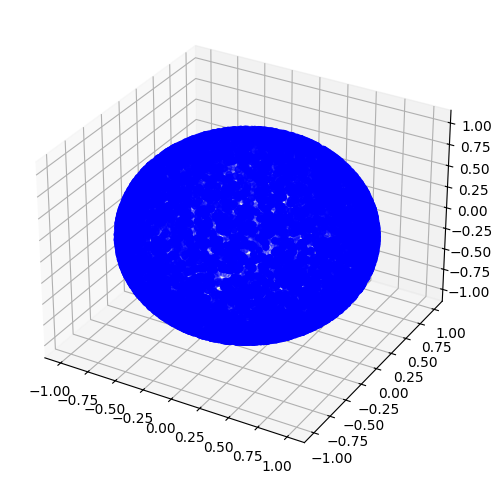

In [29]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2]
scatter = ax.scatter(x, y, z, color='blue')
plt.show()

In [30]:
# plot_vector_field_3d_lines_tf(pde_pts[:,0:3], vel_field, normalVector)

In [31]:
print(pde_pts.shape)
print(ic_pts[1][0].shape)

(10000, 4)
(10000, 1)


In [32]:
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Use a k-NN search to estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    # (Optional) consistently orient normals
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [33]:
def compute_normal_jacobian(xyz, normals, k=200, h=0.5):
    """
    xyz: (N,3)
    normals: (N,3)
    k: number of neighbors
    h: length‐scale for Gaussian weighting
    returns: (N,3,3)
    """
    N = xyz.shape[0]
    jac = np.zeros((N, 3, 3), dtype=np.float32)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)

    for i in range(N):
        neigh = indices[i, 1:]
        A = xyz[neigh] - xyz[i]         # (k,3)
        B = normals[neigh] - normals[i] # (k,3)

        # Gaussian weights, shape (k,)
        w = np.exp(- (distances[i,1:]**2) / (h*h))
        # build weighted A and B
        Wsqrt = np.sqrt(w)[:, None]     # (k,1)
        Aw = A * Wsqrt                  # each row scaled
        Bw = B * Wsqrt

        # solve Aw @ J = Bw
        J, *_ = np.linalg.lstsq(Aw, Bw, rcond=None)
        jac[i] = J

    return jac

In [34]:
normals = normalVector(pde_pts[:,0:3])
normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

In [35]:
all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
# all_pts = pde_pts # use this one for hard contraint
pmin = tf.reduce_min(all_pts, axis=0)
pmax = tf.reduce_max(all_pts, axis=0)

In [36]:
# This is a special normalize layer for this pde case only
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    # if inputs.shape[0] == 2:
    #   constant_part = inputs[0:1:,:,]
    #   other_part = inputs[1:2:,:,]
    #   other_part = 2.0*(other_part-self.xmin[1:2:,:,])/(self.xmax[1:2:,:,]-self.xmin[1:2:,:,])-1.0
    #   return tf.concat([constant_part, other_part], axis=0)
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [37]:
class FourierFeatureEmbedding(tf.keras.layers.Layer):
    def __init__(self, m, sigma, **kwargs):
        super(FourierFeatureEmbedding, self).__init__(**kwargs)
        self.m = m
        self.sigma = sigma

    def build(self, input_shape):
        num_dims = input_shape[-1]
        
        self.b = tf.random.normal(
            shape=[num_dims, self.m], 
            mean=0.0, 
            stddev=self.sigma
        )
        self.b = tf.Variable(self.b, trainable=False)
        super(FourierFeatureEmbedding, self).build(input_shape)

    def call(self, inputs):
        x_proj = tf.matmul(inputs, self.b) * 2 * np.pi
        
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

In [38]:
def buildModel(width, depth, pmin, pmax):
  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))
  b = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z, trunk_t])
  
  b = Normalize(pmin, pmax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  out = tf.keras.layers.Dense(width, activation='tanh')(b)

  out = tf.keras.layers.Dense(2, use_bias=True)(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t], out)

In [39]:
def buildModel(width, depth, pmin, pmax):
  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))
  spatial = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z])
  spatial = Normalize(pmin[0:3], pmax[0:3])(spatial)
  temporal = trunk_t
  temporal = Normalize(pmin[3], pmax[3])(temporal)

  m = features
  spatial_embedding = FourierFeatureEmbedding(m=m, sigma=sigma_spatial)(spatial)
  temporal_embedding = FourierFeatureEmbedding(m=m, sigma=sigma_temporal)(temporal)


  backbone = tf.keras.Sequential(name='shared_backbone')
  for _ in range(depth):
      backbone.add(tf.keras.layers.Dense(width, activation='tanh'))
  
  out_spatial = backbone(spatial_embedding)
  out_temporal = backbone(temporal_embedding)

  # b = out_spatial
  # for i in range(depth):
  #   b = tf.keras.layers.Dense(width, activation='tanh')(b)
  # out_spatial = tf.keras.layers.Dense(width, activation='tanh')(b)

  # b = out_temporal
  # for i in range(depth):
  #   b = tf.keras.layers.Dense(width, activation='tanh')(b)
  # out_temporal = tf.keras.layers.Dense(width, activation='tanh')(b)

  out = tf.keras.layers.Multiply()([out_spatial, out_temporal])

  out = tf.keras.layers.Dense(2, use_bias=True)(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t], out)

In [40]:
# model = buildModel(width, depth, modes)

# x, y, z, t = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2], pde_pts[:,3]
# output = tf.squeeze(model([x, y, z, t]))

# output.shape

In [41]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [42]:
# def hardConstraint(model, x, y, z, t, init, tmin=tmin, tmax=tmax):
#     x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
#     nn = model([x, y, z, t])

#     uv0 = init

#     u = uv0 + (t - tmin) / (tmax - tmin) * nn
#     # u = initial(x, y, z, radii) + nn

#     return u

In [43]:
# def hardConstraint(model, x, y, z, t, init, tmin=tmin, tmax=tmax):
#     x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
#     nn = model([x, y, z, t])

#     # uv0 = tf.concat(initial(x,y,z), axis=-1)
#     uv0 = init

#     u = uv0 + (t - tmin) / (tmax - tmin) * nn
#     # u = initial(x, y, z, radii) + nn

#     return u

In [44]:
def hardConstraint(model, x, y, z, t, step, models, prev_inits, intervals, tmin, tmax):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t])
    if step == 1:
        uv0 =  tf.concat(initial(x, y, z), axis=-1)

    else:
        # Use previous model directly
        prev_model = models[step-2]
        t_boundary = tf.ones_like(x) * tmin  # boundary time
        prev_nn = prev_model([x, y, z, t_boundary])
        
        # You'll need to store previous model's time range
        prev_uv0 = prev_inits[step-2]
        prev_tmin, prev_tmax = intervals[step-2]
        uv0 = prev_uv0 + (t_boundary - prev_tmin) / (prev_tmax - prev_tmin) * prev_nn
    
    u = uv0 + (t - tmin) / (tmax - tmin) * nn
    return u

In [45]:
def hardConstraint(model, x, y, z, t, step, models, prev_inits, intervals, tmin, tmax):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t])
    return nn

In [46]:
# output = tf.squeeze(hardConstraint(model, x, y, z, t))

In [47]:
@tf.function
def f(pde_pts, normals, normal_jacobian):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  # x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

  with tf.GradientTape() as tape:
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, y, z, t])

        net = u_analytic(x, y, z, t)

        u_pde = net[0]
        v_pde = net[1]  

        ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

        # uncomment for laplacian
        uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

        uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

        vx, vy, vz, vt = tape2.gradient(v_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

        # uncomment for laplacian
        vxx = tape2.gradient(vx, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        vyy = tape2.gradient(vy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        vzz = tape2.gradient(vz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

        vxy = tape2.gradient(vx, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        vxz = tape2.gradient(vx, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        vyz = tape2.gradient(vy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        
      u_grads = tf.squeeze(tf.stack([ux, uy, uz], axis=1))

      u_laplacians = uxx + uyy + uzz

      u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

      # uncomment for laplacian
      row0 = tf.stack([uxx, uxy, uxz], axis=1)
      row1 = tf.stack([uxy, uyy, uyz], axis=1) 
      row2 = tf.stack([uxz, uyz, uzz], axis=1) 
      u_hessian = tf.squeeze(tf.stack([row0, row1, row2], axis=1))

      u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

      u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
      
      # surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

      u_surface_laplacians = tf.squeeze(u_laplacians) - u_surface_hess * u_directional_nu - u_directional_nu_second

      v_grads = tf.squeeze(tf.stack([vx, vy, vz], axis=1))

      v_laplacians = vxx + vyy + vzz

      v_directional_nu = tf.reduce_sum(normals * v_grads, axis=1) # Directional derivatives of v in direction of the normal

      # uncomment for laplacian
      row0 = tf.stack([vxx, vxy, vxz], axis=1)
      row1 = tf.stack([vxy, vyy, vyz], axis=1) 
      row2 = tf.stack([vxz, vyz, vzz], axis=1) 
      v_hessian = tf.squeeze(tf.stack([row0, row1, row2], axis=1))

      v_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(v_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

      v_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

      v_surface_laplacians = tf.squeeze(v_laplacians) - v_surface_hess * v_directional_nu - v_directional_nu_second

      # eps = 0.01
      # a = 0.5
      # beta = 0.8
      # vega = 0.0001
      # alpha = 1.0

      ut, vt = tf.squeeze(ut), tf.squeeze(vt)
      u_pde, v_pde = tf.squeeze(u_pde), tf.squeeze(v_pde)
      
      gamma = 500.0
      vega = 200.0

      eqn1 = (ut - gamma * (a - u_pde + u_pde**2 * v_pde) - u_surface_laplacians) / gamma
      eqn2 = (vt - gamma * (b - u_pde**2 * v_pde) - vega * v_surface_laplacians) / gamma

      # eqn1 = tf.squeeze(ut) - eps ** 2 * u_surface_laplacians + tf.squeeze((u_pde ** 3 - u_pde))
      # eqn2 = tf.squeeze(vt) - eps ** 2 * v_surface_laplacians + tf.squeeze((v_pde ** 3 - v_pde))

  return [eqn1, eqn2]

In [48]:
# @tf.function
def trainingStep(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)

  xi, yi, zi, ti = tf.split(ic_pts[0], 4, axis=1)
  xi, yi, zi, ti = tf.squeeze(xi), tf.squeeze(yi), tf.squeeze(zi), tf.squeeze(ti)
  ui = tf.concat(ic_pts[1], axis=-1)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])
      net = tf.squeeze(hardConstraint(model, x, y, z, t, step, models, init, intervals, tmin=min_time, tmax=max_time))
      u_pde = net[:,0]
      v_pde = net[:,1]  

      ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # uncomment for laplacian
      uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vx, vy, vz, vt = tape2.gradient(v_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # # uncomment for laplacian
      vxx = tape2.gradient(vx, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyy = tape2.gradient(vy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vzz = tape2.gradient(vz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vxy = tape2.gradient(vx, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vxz = tape2.gradient(vx, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyz = tape2.gradient(vy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      
    u_grads = tf.stack([ux, uy, uz], axis=1)

    u_laplacians = uxx + uyy + uzz

    u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    u_hessian = tf.stack([row0, row1, row2], axis=1)

    u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    # surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

    u_surface_laplacians = u_laplacians - u_surface_hess * u_directional_nu - u_directional_nu_second

    v_grads = tf.stack([vx, vy, vz], axis=1)

    v_laplacians = vxx + vyy + vzz

    v_directional_nu = tf.reduce_sum(normals * v_grads, axis=1) # Directional derivatives of v in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([vxx, vxy, vxz], axis=1)
    row1 = tf.stack([vxy, vyy, vyz], axis=1) 
    row2 = tf.stack([vxz, vyz, vzz], axis=1) 
    v_hessian = tf.stack([row0, row1, row2], axis=1)

    v_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(v_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    v_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

    v_surface_laplacians = v_laplacians - v_surface_hess * v_directional_nu - v_directional_nu_second

    force_term = f(pde_pts, normals, normal_jacobian)
    
    gamma = 500.0
    vega = 200.0

    eqn1 = (ut - gamma * (a - u_pde + u_pde**2 * v_pde) - u_surface_laplacians) / gamma - force_term[0]
    eqn2 = (vt - gamma * (b - u_pde**2 * v_pde) - vega * v_surface_laplacians) / gamma - force_term[1]
    # eqn1 = ut - u_surface_laplacians
    # eqn2 = vt - v_surface_laplacians

    pde_loss = tf.reduce_mean(eqn1**2) + tf.reduce_mean(eqn2**2)

    u_init_pred = hardConstraint(model, xi, yi, zi, ti, step, models, init, intervals, tmin=min_time, tmax=max_time)

    ic_loss = tf.reduce_mean((u_init_pred - ui)**2)

    loss = lambda_pde * pde_loss + lambda_ic * ic_loss

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, pde_loss, ic_loss, grads, u_pde, v_pde

In [49]:
def final_hard_constraint(model, x, y, z, t, tmin=tmin, tmax=tmax):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t])

    uv0 = tf.concat(initial(x,y,z), axis=-1)

    u = uv0 + (t - tmin) / (tmax - tmin) * nn
    # u = initial(x, y, z, radii) + nn

    return nn

In [50]:
@tf.function
def final_training_step(model, optimizer, pde_pts, ic_pts, data, init, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, lambda_d=1.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)
  xyz = tf.stack([x, y, z], axis=1)

  xi, yi, zi, ti = tf.split(ic_pts[0], 4, axis=1)
  xi, yi, zi, ti = tf.squeeze(xi), tf.squeeze(yi), tf.squeeze(zi), tf.squeeze(ti)
  ui = tf.concat(ic_pts[1], axis=-1)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])

      net = tf.squeeze(final_hard_constraint(model, x, y, z, t, min_time, max_time))

      u_pde = net[:,0]
      v_pde = net[:,1]  

      ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # uncomment for laplacian
      uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vx, vy, vz, vt = tape2.gradient(v_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

      # # uncomment for laplacian
      vxx = tape2.gradient(vx, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyy = tape2.gradient(vy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vzz = tape2.gradient(vz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

      vxy = tape2.gradient(vx, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vxz = tape2.gradient(vx, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      vyz = tape2.gradient(vy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
      
    u_grads = tf.stack([ux, uy, uz], axis=1)

    u_laplacians = uxx + uyy + uzz

    u_directional_nu = tf.reduce_sum(normals * u_grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([uxx, uxy, uxz], axis=1)
    row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    u_hessian = tf.stack([row0, row1, row2], axis=1)

    u_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(u_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    u_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    # surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

    u_surface_laplacians = u_laplacians - u_surface_hess * u_directional_nu - u_directional_nu_second

    v_grads = tf.stack([vx, vy, vz], axis=1)

    v_laplacians = vxx + vyy + vzz

    v_directional_nu = tf.reduce_sum(normals * v_grads, axis=1) # Directional derivatives of v in direction of the normal

    # uncomment for laplacian
    row0 = tf.stack([vxx, vxy, vxz], axis=1)
    row1 = tf.stack([vxy, vyy, vyz], axis=1) 
    row2 = tf.stack([vxz, vyz, vzz], axis=1) 
    v_hessian = tf.stack([row0, row1, row2], axis=1)

    v_directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(v_hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    v_surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))

    v_surface_laplacians = v_laplacians - v_surface_hess * v_directional_nu - v_directional_nu_second

    force_term = f(pde_pts, normals, normal_jacobian)
    
    gamma = 500.0
    vega = 200.0

    eqn1 = (ut - gamma * (a - u_pde + u_pde**2 * v_pde) - u_surface_laplacians) / gamma - force_term[0]
    eqn2 = (vt - gamma * (b - u_pde**2 * v_pde) - vega * v_surface_laplacians) / gamma - force_term[1]
    # eqn1 = ut - u_surface_laplacians
    # eqn2 = vt - v_surface_laplacians

    pde_loss = tf.reduce_mean(eqn1**2) + tf.reduce_mean(eqn2**2)

    u_init_pred = tf.squeeze(final_hard_constraint(model, xi, yi, zi, ti, min_time, max_time))

    ic_loss = tf.reduce_mean((u_init_pred - ui)**2)
    # ic_loss = 0.0

    data_loss = tf.reduce_mean((net - data)**2)

    loss = lambda_pde * pde_loss + lambda_ic * ic_loss +  lambda_d * data_loss

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss, pde_loss, ic_loss, data_loss, grads, u_pde, v_pde

In [51]:
def train(ts, model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=False, data=None, epochs=1000):
  losses = []
  pde_losses = []
  ic_losses = []
  l2s = []
  uv2 = []

  batch_size = N_inputs

  # dataset = (
  # tf.data.Dataset.from_tensor_slices((pde_pts, ic_pts, init, normals, normal_jacobian))
  # .shuffle(N_inputs)
  # .batch(batch_size)
  # .prefetch(tf.data.AUTOTUNE)
  #           )

  ran_lbfgs = False

  # for epoch in range(epochs):   
  #   avg_loss = 0.0
  #   for pde_batch, ic_batch, radii_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
  #     if epoch < epochs // 2:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0) 
  #       avg_loss += loss  
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #     else:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
  #       avg_loss += loss
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #   losses.append(avg_loss / batch_size)

  for epoch in range(epochs):
    avg_loss = 0.0
    # for pde_batch, ic_batch, radii_batch, u_sensor_batch, v_sensor_batch, normals_batch, normal_jac_batch in dataset:
    #   loss, pde_loss, ic_loss, grads, u_pred, v_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, v_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
      # avg_loss += loss
    if not final:
      loss, pde_loss, ic_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)    
    else:
      loss, pde_loss, ic_loss, data_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, data, init, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, lambda_d=1.0)    
    # losses.append(avg_loss / batch_size)
    losses.append(loss)

    if epoch % 100 == 0:
      x, y, z, t = pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], pde_pts[:,3:4]
      u_pred = model([x, y, z, t])
      x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
      u_true = tf.concat(u_analytic(x, y, z, t), axis=1)

      l2 = tf.norm(u_true - u_pred) / tf.norm(u_true)
      l2s.append(l2)

      mae = tf.reduce_mean(tf.abs(u_true - u_pred))

      print(f"Epoch {epoch} - PDE Loss {pde_loss: .6f} - IC Loss {ic_loss: .6f} - Total Loss {loss: .6f} - L2 {l2: .6f} - MAE {mae: .6f}")
      if final:
        print(f"Data loss {data_loss: .6f}")
      print("mean u:", tf.reduce_mean(u_pred).numpy())
      # print("std u:", tf.math.reduce_std(u_pred).numpy())
      print("mean v:", tf.reduce_mean(v_pred).numpy())
      # print("std v:", tf.math.reduce_std(v_pred).numpy())
  
  return losses, pde_losses, ic_losses, l2s, grads, uv2

In [52]:
def train(ts, model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=False, data=None, epochs=1000):
  losses = []
  pde_losses = []
  ic_losses = []
  l2s = []
  uv2 = []
  batch_size = N_inputs
  # if not final:
  #   dataset = (
  #   tf.data.Dataset.from_tensor_slices((pde_pts, ic_pts[0], tf.concat(ic_pts[1], axis=-1), normals, normal_jacobian))
  #   .shuffle(N_inputs)
  #   .batch(batch_size)
  #   .prefetch(tf.data.AUTOTUNE)
  #               )
  # else:
  #   dataset = (
  #   tf.data.Dataset.from_tensor_slices((pde_pts, ic_pts[0], tf.concat(ic_pts[1], axis=-1), data, normals, normal_jacobian))
  #   .shuffle(N_inputs)
  #   .batch(batch_size)
  #   .prefetch(tf.data.AUTOTUNE)
  #               )

  ran_lbfgs = False

  # for epoch in range(epochs):   
  #   avg_loss = 0.0
  #   for pde_batch, ic_batch, radii_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
  #     if epoch < epochs // 2:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0) 
  #       avg_loss += loss  
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #     else:
  #       loss, pde_loss, ic_loss, grads, u_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
  #       avg_loss += loss
  #       # losses.append(loss)
  #       # pde_losses.append(pde_loss)
  #       # ic_losses.append(ic_loss)
  #   losses.append(avg_loss / batch_size)

  for epoch in range(epochs):
    avg_loss = 0.0
    # for pde_batch, ic_batch, radii_batch, u_sensor_batch, v_sensor_batch, normals_batch, normal_jac_batch in dataset:
    #   loss, pde_loss, ic_loss, grads, u_pred, v_pred = trainingStep(model, optimizer, pde_batch, ic_batch, u_sensor_batch, v_sensor_batch, radii_batch, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)   
      # avg_loss += loss
    if not final:
      loss, pde_loss, ic_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)    
      # for pde_batch, ic1_batch, ic2_batch, normals_batch, normal_jac_batch in dataset:
      #   ic_batch = [ic1_batch, [ic2_batch[:,0:1], ic2_batch[:,1:2]]]
      #   loss, pde_loss, ic_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_batch, ic_batch, step, init, models, intervals, min_time, max_time, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, alpha=0.0)    
      #   avg_loss += loss
    else:
      loss, pde_loss, ic_loss, data_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_pts, ic_pts, data, init, min_time, max_time, normals, normal_jacobian, lambda_ic=1.0, lambda_pde=1.0, lambda_d=1.0)
      # for pde_batch, ic1_batch, ic2_batch, data_batch, normals_batch, normal_jac_batch in dataset:
      #   ic_batch = [ic1_batch, [ic2_batch[:,0:1], ic2_batch[:,1:2]]]
      #   loss, pde_loss, ic_loss, data_loss, grads, u_pred, v_pred = ts(model, optimizer, pde_batch, ic_batch, data_batch, init, min_time, max_time, normals_batch, normal_jac_batch, lambda_ic=1.0, lambda_pde=1.0, lambda_d=1.0)
      #   avg_loss += loss    
    # losses.append(avg_loss / batch_size)
    # losses.append(avg_loss / batch_size)
    losses.append(loss)

    if epoch % 100 == 0:
      x, y, z, t = pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], pde_pts[:,3:4]
      u_pred = model([x, y, z, t])
      x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
      u_true = tf.concat(u_analytic(x, y, z, t), axis=1)

      l2 = tf.norm(u_true - u_pred) / tf.norm(u_true)
      l2s.append(l2)

      mae = tf.reduce_mean(tf.abs(u_true - u_pred))

      print(f"Epoch {epoch} - PDE Loss {pde_loss: .6f} - IC Loss {ic_loss: .6f} - Total Loss {loss: .6f} - L2 {l2: .6f} - MAE {mae: .6f}")
      if final:
        print(f"Data loss {data_loss: .6f}")
      print("mean u:", tf.reduce_mean(u_pred).numpy())
      # print("std u:", tf.math.reduce_std(u_pred).numpy())
      print("mean v:", tf.reduce_mean(v_pred).numpy())
      # print("std v:", tf.math.reduce_std(v_pred).numpy())
  
  return losses, pde_losses, ic_losses, l2s, grads, uv2

In [53]:
# model = buildModel(width, depth, modes)

In [54]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.5)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [56]:
# model.save_weights('fh209.weights.h5')

In [57]:
def build_init(steps, models, x, y, z, intervals):
    """
    Pre-build the chain of initial conditions in a differentiable way
    """
    init_conditions = []
    
    # First condition
    first_init = tf.concat(initial(x, y, z), axis=-1)
    init_conditions.append(first_init)
    
    # Build subsequent conditions
    for i in range(1, steps):
        prev_model = models[i-1]
        prev_tmin, prev_tmax = intervals[i-1]
        curr_tmin, curr_tmax = intervals[i]

        # Boundary time (end of previous interval)
        t_boundary = tf.ones_like(x) * curr_tmin
        
        # Get previous model's prediction at boundary
        prev_nn = prev_model([x, y, z, t_boundary])
        prev_uv0 = init_conditions[i-1]
        
        # Compute boundary value using previous model's hard constraint

        boundary_value = prev_nn
        init_conditions.append(boundary_value)
    
    return init_conditions

In [58]:
def prediction(x, y, z, t,  models, intervals):
    preds = []
    out_shape = tf.shape(x)
    out_dim = 2
    preds = tf.zeros([out_shape[0], out_dim], dtype=tf.float32)
    for j in range(len(models)):
        print(j)
        min_t = intervals[j][0]
        max_t = intervals[j][1]
        mask = tf.where((t >= min_t) & (t <= max_t), True, False)
        indices_j = tf.where(mask)[:, 0]
        xj, yj, zj, tj = tf.boolean_mask(x, mask, axis=0), tf.boolean_mask(y, mask, axis=0), tf.boolean_mask(z, mask, axis=0), tf.boolean_mask(t, mask, axis=0)
        xj, yj, zj, tj = tf.reshape(xj, [-1, 1]), tf.reshape(yj, [-1, 1]), tf.reshape(zj, [-1, 1]), tf.reshape(tj, [-1, 1])
        intervals_j = intervals[:j+1]
        mj = models[j]

        inits_j = build_init(j+1, models[:j], xj, yj, zj, intervals_j)
        # print(models[:j])

        mi_pred = mj([xj, yj, zj, tj])
        # preds.append(mi_pred)
        preds = tf.tensor_scatter_nd_update(
            preds, tf.expand_dims(indices_j, axis=1), mi_pred
        )

    return preds

max time: 0.049999999999999996, min_time 0.0
Epoch 0 - PDE Loss  30398468.000000 - IC Loss  0.144281 - Total Loss  30398468.000000 - L2  1.026164 - MAE  0.303794
mean u: -0.001214326
mean v: 0.00062806654
Epoch 100 - PDE Loss  21350.054688 - IC Loss  0.095677 - Total Loss  21350.150391 - L2  0.829646 - MAE  0.245492
mean u: 0.042491313
mean v: -0.005459679
Epoch 200 - PDE Loss  8464.049805 - IC Loss  0.061417 - Total Loss  8464.111328 - L2  0.663717 - MAE  0.201385
mean u: 0.086080626
mean v: -0.0065090517
Epoch 300 - PDE Loss  4738.134766 - IC Loss  0.038336 - Total Loss  4738.173340 - L2  0.523424 - MAE  0.163839
mean u: 0.119971335
mean v: -0.014865897
Epoch 400 - PDE Loss  3097.858643 - IC Loss  0.023577 - Total Loss  3097.882324 - L2  0.409630 - MAE  0.132883
mean u: 0.14630792
mean v: -0.026699759
Epoch 500 - PDE Loss  2204.380371 - IC Loss  0.014750 - Total Loss  2204.395020 - L2  0.323442 - MAE  0.108058
mean u: 0.16734588
mean v: -0.037751254
Epoch 600 - PDE Loss  1662.337158 

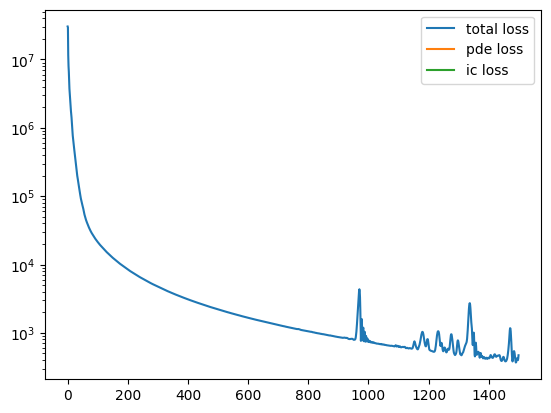

max time: 0.09999999999999999, min_time 0.049999999999999996
Epoch 0 - PDE Loss  22315114.000000 - IC Loss  0.145020 - Total Loss  22315114.000000 - L2  1.017611 - MAE  0.298816
mean u: -0.0018736686
mean v: 0.00088133727
Epoch 100 - PDE Loss  12366.409180 - IC Loss  0.090737 - Total Loss  12366.500000 - L2  0.811826 - MAE  0.239534
mean u: 0.050027717
mean v: 0.00072421465
Epoch 200 - PDE Loss  5055.025391 - IC Loss  0.057004 - Total Loss  5055.082520 - L2  0.642372 - MAE  0.194962
mean u: 0.08919949
mean v: -0.0108326385
Epoch 300 - PDE Loss  2838.264893 - IC Loss  0.035274 - Total Loss  2838.300049 - L2  0.503901 - MAE  0.158358
mean u: 0.12094627
mean v: -0.022967098
Epoch 400 - PDE Loss  1846.552490 - IC Loss  0.021527 - Total Loss  1846.573975 - L2  0.392349 - MAE  0.127210
mean u: 0.15228496
mean v: -0.022606106
Epoch 500 - PDE Loss  1308.441284 - IC Loss  0.013077 - Total Loss  1308.454346 - L2  0.304797 - MAE  0.100913
mean u: 0.18473938
mean v: -0.0077861864
Epoch 600 - PDE L

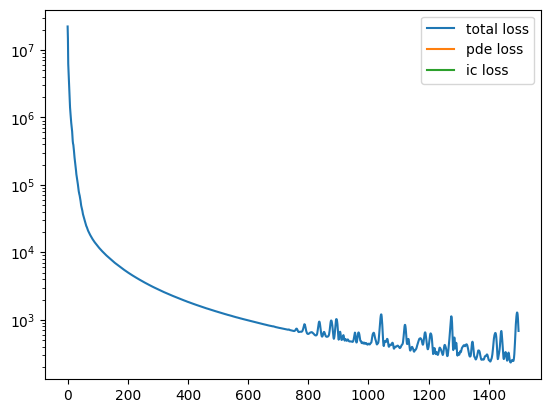

max time: 0.15, min_time 0.09999999999999999
Epoch 0 - PDE Loss  31867486.000000 - IC Loss  0.144824 - Total Loss  31867486.000000 - L2  1.020048 - MAE  0.296893
mean u: -0.00027965484
mean v: 0.0012068659
Epoch 100 - PDE Loss  16489.369141 - IC Loss  0.090302 - Total Loss  16489.458984 - L2  0.808863 - MAE  0.237458
mean u: 0.04283729
mean v: -0.015139771
Epoch 200 - PDE Loss  6482.900391 - IC Loss  0.056341 - Total Loss  6482.956543 - L2  0.637905 - MAE  0.192586
mean u: 0.08645873
mean v: -0.017957706
Epoch 300 - PDE Loss  3603.590576 - IC Loss  0.034390 - Total Loss  3603.625000 - L2  0.496711 - MAE  0.156092
mean u: 0.11608814
mean v: -0.036543347
Epoch 400 - PDE Loss  2340.089844 - IC Loss  0.021389 - Total Loss  2340.111328 - L2  0.390506 - MAE  0.128147
mean u: 0.1374261
mean v: -0.059520073
Epoch 500 - PDE Loss  1664.385986 - IC Loss  0.014440 - Total Loss  1664.400391 - L2  0.320804 - MAE  0.106798
mean u: 0.15468489
mean v: -0.07826694
Epoch 600 - PDE Loss  1302.202759 - IC 

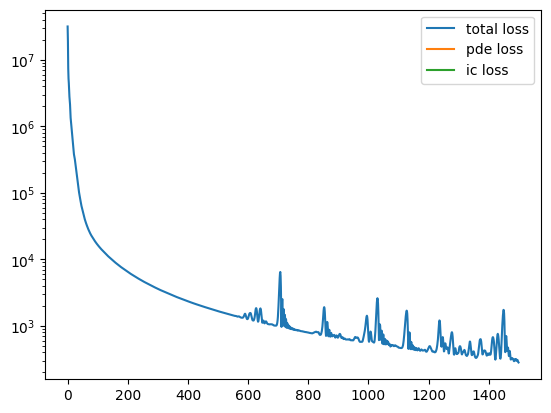

max time: 0.15, min_time 0.0
0
1
2
Epoch 0 - PDE Loss  39356064.000000 - IC Loss  0.149231 - Total Loss  39356064.000000 - L2  1.019051 - MAE  0.296427
Data loss  0.150693
mean u: -0.0010395141
mean v: -0.001445932
Epoch 100 - PDE Loss  18015.707031 - IC Loss  0.091881 - Total Loss  18015.892578 - L2  0.818725 - MAE  0.241072
Data loss  0.093010
mean u: 0.04665545
mean v: -0.0025935865
Epoch 200 - PDE Loss  7140.293457 - IC Loss  0.059722 - Total Loss  7140.413574 - L2  0.658976 - MAE  0.198794
Data loss  0.060467
mean u: 0.091647096
mean v: 0.0028837246
Epoch 300 - PDE Loss  3975.493164 - IC Loss  0.037650 - Total Loss  3975.568848 - L2  0.521661 - MAE  0.161925
Data loss  0.037964
mean u: 0.12959939
mean v: 0.00498637
Epoch 400 - PDE Loss  2580.807373 - IC Loss  0.023143 - Total Loss  2580.853516 - L2  0.407375 - MAE  0.130362
Data loss  0.023087
mean u: 0.15977503
mean v: 0.0024002634
Epoch 500 - PDE Loss  1830.267700 - IC Loss  0.014144 - Total Loss  1830.295654 - L2  0.317053 - MA

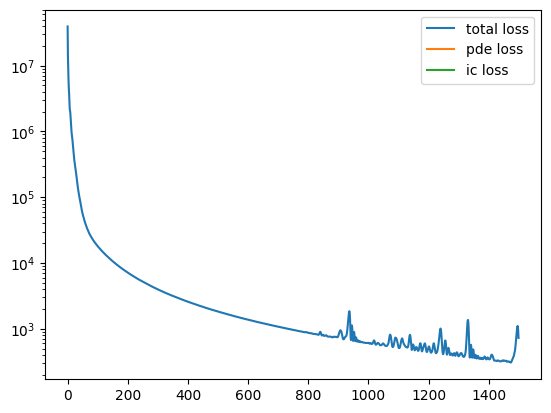

In [59]:
steps = 3
models = []
inits = []
intervals = []
for i in range(1, steps+2):
    epochs = 1500
    max_time = i * tmax / steps
    if i == steps + 1:
        max_time = tmax
        min_time = 0.0
        # epochs = 4 * epochs
    elif i == 1:
        min_time = 0.0
    else:
        min_time = ((i-1) * tmax / steps)
    print(f"max time: {max_time}, min_time {min_time}")
    intervals.append((min_time, max_time))
    pde_pts, ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=min_time, tmax=max_time)
    x, y, z, t = pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], pde_pts[:,3:4]
    normals =  tf.convert_to_tensor(normalVector(pde_pts[:,0:3]), dtype=tf.float32)
    normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals.numpy()), dtype=tf.float32)
    # init = tf.concat(initial(x, y, z), axis=-1)
    if i != steps+1:
        init = build_init(i, models, x, y, z, intervals)
        # if i == 1:
        #     init = initial(x, y, z)
        #     init = tf.concat(init, axis=-1)
        #     inits.append(init)
        
        # elif i != 1:
        #     init = hardConstraint(model, x, y, z, tf.ones_like(x) * min_time, i, models, inits, intervals, min_time, max_time)
        #     inits.append(init)

        @tf.function(reduce_retracing=True)
        def ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0): 
            return trainingStep(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0)
        all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
        pmin = tf.reduce_min(all_pts, axis=0)
        pmax = tf.reduce_max(all_pts, axis=0)
        model = buildModel(width, depth, pmin, pmax)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        losses, pde_losses, ic_losses, l2s, grads, uv2 = train(ts, model, optimizer, pde_pts, ic_pts, i, init, models, intervals, min_time, max_time, normals, normal_jacobian, epochs=epochs)

    else:
        init = initial(x, y, z)
        init = tf.concat(init, axis=-1)   
        inits.append(init)
        inits_j = []  
        intervals_j = []


        all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
        pmin = tf.reduce_min(all_pts, axis=0)
        pmax = tf.reduce_max(all_pts, axis=0)
        model = buildModel(150, 8, pmin, pmax)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        normals = normalVector(pde_pts[:,0:3])
        normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

        data = prediction(x, y, z, t, models, intervals)

        losses, pde_losses, ic_losses, l2s, grads, uv2 = train(final_training_step, model, optimizer, pde_pts, ic_pts, 0, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=True, data=data, epochs=1500)

    models.append(model)

# if i % 25 == 0:
#     model.save_weights('fitz_hugh_sphere.weights.h5')
#     print('Saved weights!')
# if i == steps:
#     model.save_weights('fitz_hugh_sphere.weights.h5')
#     print('Saved weights and finished training!')        
    losses = [l.numpy() for l in losses]
    pde_losses = [l.numpy() for l in pde_losses]
    ic_losses = [l.numpy() for l in ic_losses]
    plt.plot(losses, label='total loss')
    plt.plot(pde_losses, label='pde loss')
    plt.plot(ic_losses, label='ic loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

In [60]:
# steps = 20
# i = 100
# epochs = 500
# max_time = i * tmax / steps
# if i == 100:
#     max_time = tmax
#     min_time = 0.0
#     # epochs = 4 * epochs
# else:
#     min_time = ((i-1) * tmax / steps)
# print(f"max time: {max_time}, min_time {min_time}")
# intervals.append((min_time, max_time))
# pde_pts, ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=min_time, tmax=max_time)
# x, y, z, t = pde_pts[:,0:1], pde_pts[:,1:2], pde_pts[:,2:3], pde_pts[:,3:4]
# normals =  tf.convert_to_tensor(normalVector(pde_pts[:,0:3]), dtype=tf.float32)
# normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals.numpy()), dtype=tf.float32)
# # init = tf.concat(initial(x, y, z), axis=-1)
# if i != 100:
#     init = build_init(i, models, x, y, z, intervals)
#     # if i == 1:
#     #     init = initial(x, y, z)
#     #     init = tf.concat(init, axis=-1)
#     #     inits.append(init)
    
#     # elif i != 1:
#     #     init = hardConstraint(model, x, y, z, tf.ones_like(x) * min_time, i, models, inits, intervals, min_time, max_time)
#     #     inits.append(init)

#     @tf.function(reduce_retracing=True)
#     def ts(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0): 
#         return trainingStep(model, optimizer, pde_pts, ic_pts, step, init, models, intervals, min_time, max_time, normals, normal_jacobian, lambda_pde=1.0, lambda_ic=1.0, alpha=0.0)
#     all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
#     pmin = tf.reduce_min(all_pts, axis=0)
#     pmax = tf.reduce_max(all_pts, axis=0)
#     model = buildModel(width, depth, pmin, pmax)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#     losses, pde_losses, ic_losses, l2s, grads, uv2 = train(ts, model, optimizer, pde_pts, ic_pts, i, init, models, intervals, min_time, max_time, normals, normal_jacobian, epochs=epochs)

# elif i == 100:
#     init = initial(x, y, z)
#     init = tf.concat(init, axis=-1)   
#     inits.append(init)
#     inits_j = []  
#     intervals_j = []


#     all_pts = tf.concat([pde_pts, ic_pts[0]], axis=0) # use this one for soft constraints
#     pmin = tf.reduce_min(all_pts, axis=0)
#     pmax = tf.reduce_max(all_pts, axis=0)
#     model = buildModel(width, 4, pmin, pmax)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
#     normals = normalVector(pde_pts[:,0:3])
#     normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

#     data = prediction(x, y, z, t, models, intervals)

#     losses, pde_losses, ic_losses, l2s, grads, uv2 = train(final_training_step, model, optimizer, pde_pts, ic_pts, 0, init, models, intervals, min_time, max_time, normals, normal_jacobian, final=True, data=data, epochs=10000)

# models.append(model)

# # if i % 25 == 0:
# #     model.save_weights('fitz_hugh_sphere.weights.h5')
# #     print('Saved weights!')
# # if i == steps:
# #     model.save_weights('fitz_hugh_sphere.weights.h5')
# #     print('Saved weights and finished training!')        
# losses = [l.numpy() for l in losses]
# pde_losses = [l.numpy() for l in pde_losses]
# ic_losses = [l.numpy() for l in ic_losses]
# plt.plot(losses, label='total loss')
# plt.plot(pde_losses, label='pde loss')
# plt.plot(ic_losses, label='ic loss')
# plt.legend()
# plt.yscale('log')
# plt.show()

In [61]:
# losses, pde_losses, ic_losses, l2s, grads, uv2 = train(model, optimizer, pde_pts, ic_pts, u_sc, v_sc, radii, normals, normal_jacobian, epochs=5000)
# losses = [l.numpy() for l in losses]
# pde_losses = [l.numpy() for l in pde_losses]
# ic_losses = [l.numpy() for l in ic_losses]
# uv2s = [l for l in uv2]

In [62]:
# model.save_weights('sphere_gs.weights.h5')

In [63]:
# plt.plot(losses, label='total loss')
# plt.plot(pde_losses, label='pde loss')
# plt.plot(ic_losses, label='ic loss')
# plt.legend()
# # plt.xscale('log')
# plt.yscale('log')

In [64]:
# plt.plot(uv2s)
# plt.yscale('log')

In [65]:
print(tf.random.normal((1,)))

tf.Tensor([0.29622614], shape=(1,), dtype=float32)


In [66]:
intervals

[(0.0, 0.049999999999999996),
 (0.049999999999999996, 0.09999999999999999),
 (0.09999999999999999, 0.15),
 (0.0, 0.15)]

In [67]:
test_pde_pts, test_ic_pts = generatePoints(N_inputs, sphere, umin=0.0, umax=np.pi, vmin=0.0, vmax=2*np.pi, tmin=0.0, tmax=tmax)

n_eval_pts = 100

mean_u_mae = tf.constant([0.0], dtype=tf.float32)
mean_u_l2 = tf.constant([0.0], dtype=tf.float32)
mean_v_mae = tf.constant([0.0], dtype=tf.float32)
mean_v_l2 = tf.constant([0.0], dtype=tf.float32)

for i in range(n_eval_pts):
    x, y, z, t = tf.split(test_pde_pts, 4, axis=1)

    u_pred = models[-1]([x, y, z, t])
    # u_pred = prediction(x, y, z, t, models, intervals)
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    u_true = tf.concat(u_analytic(x, y, z, t), axis=1)
    u_l2 = tf.norm(u_true[:,0] - u_pred[:,0]) / tf.norm(u_true[:,0])
    v_l2 = tf.norm(u_true[:,1] - u_pred[:,1]) / tf.norm(u_true[:,1])

    u_mae = tf.reduce_mean(tf.abs(u_pred[:,0] - u_true[:,0]))
    v_mae = tf.reduce_mean(tf.abs(u_pred[:,1] - u_true[:,1]))

    mean_u_mae += u_mae
    mean_u_l2 += u_l2
    mean_v_mae += v_mae
    mean_v_l2 += v_l2

print(f"Average u MAE over {n_eval_pts} initial conditions: {float(mean_u_mae / n_eval_pts): .4f}")
print(f"Average v MAE over {n_eval_pts} initial conditions: {float(mean_v_mae / n_eval_pts): .4f}")
print(f"Average u L2 over {n_eval_pts} initial conditions: {float(mean_u_l2 / n_eval_pts): .4f}")
print(f"Average v L2 over {n_eval_pts} initial conditions: {float(mean_v_l2 / n_eval_pts): .4f}")

Average u MAE over 100 initial conditions:  0.0079
Average v MAE over 100 initial conditions:  0.0663
Average u L2 over 100 initial conditions:  0.0197
Average v L2 over 100 initial conditions:  1.0041


In [68]:
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])

In [69]:
def modelResults(model, surface, umin=0.0, umax=1.0, vmin=0.0, vmax=1.0, t_steps=3, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  test_pde_pts, _ = generatePoints(resolution, sphere, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, tmin=tmin, tmax=tmax)

  x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]

  # norm_actual, norm_pred, colors_actual, colors_pred = None, None, None, None
  init = tf.concat(initial(x, y, z), axis=-1)

  u_norm_pred = None
  v_norm_pred = None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps) + 1e-6
    pde_pts = tf.stack([x, y, z, t], axis=1)

    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

    print(f"t={i * tmax / t_steps}")
    u_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,0], x.shape).numpy()
    # u_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,0], x.shape).numpy()
    if i == i: 
      u_norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()
  
    UP = u_pred.ravel()             

    fig = plt.figure(figsize=(18, 6))

    ax2    = fig.add_subplot(121, projection='3d')

    ax2.set_box_aspect([1, 1, 1])

    u_sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='magma',
        norm=u_norm_pred,
        marker='o'
    )

    fig.colorbar(u_sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax2,    x, y, z)

    ax2.view_init(elev=15, azim=-20)

    v_pred = tf.reshape(final_hard_constraint(models[-1], x, y, z, t, tmin=tmin, tmax=tmax)[:,1], x.shape).numpy()
    # v_pred = tf.reshape(prediction(x, y, z, t, models, intervals)[:,1], x.shape).numpy()

    if i == i:
      v_norm_pred = plt.Normalize(vmin=v_pred.min(), vmax=v_pred.max())

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()

    VP = v_pred.ravel()             

    ax3 = fig.add_subplot(122, projection='3d')

    ax3.set_box_aspect([1, 1, 1])

    v_sc_pred = ax3.scatter(
        X, Y, Z,
        c=VP,
        cmap='magma',
        norm=v_norm_pred,
        marker='o'
    )

    fig.colorbar(v_sc_pred, ax=ax3, shrink=0.6)

    set_axes_equal_tensorflow(ax3, x, y, z)

    ax3.view_init(elev=15, azim=-20)

    plt.show()



  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

In [70]:
# modelResults(model, sphere, umin=0.0, umax=2*np.pi, vmin=0.0, vmax=2*np.pi, t_steps=5, tmax=tmax, resolution=40000, load=False, saveplots=False)

In [71]:
# model.save_weights('fitz_hugh_10.weights.h5')